In [98]:
import pandas as pd
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import os
import re
import time

from gensim.models import Word2Vec
from tqdm import tqdm

import re
import urllib.request
import zipfile
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.manifold import TSNE

In [2]:
data_df = pd.read_csv('../predicting-satisfaction-using-graphs/csv/dataset/avg_satisfaction_raw_0-999.csv', encoding='ISO-8859-1')

In [3]:
list_satisfaction = list(data_df['satisfy_composite'])
list_tag = list(data_df['postIndex'])
list_post = list(data_df['postContent'])
list_comment = list(data_df['commentContent'])

In [4]:
list_content = []
for p, c in zip(list_post, list_comment):
    list_content.append(p+' '+c)

# Word2Vec

In [64]:
def preprocessing(content_list):
    result_list = []
    for text in content_list:
        content_text = re.sub(r'\([^)]*\)', '', text)
        sent_text = sent_tokenize(content_text)
        normalized_text = []
        for string in sent_text:
             tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
             normalized_text.append(tokens)
        result_list.extend([word_tokenize(sentence) for sentence in normalized_text])
    
    return result_list

In [65]:
post_sentences = preprocessing(list_post)
comment_sentences = preprocessing(list_comment)
content_sentences = preprocessing(list_content)

In [110]:
def train_word2vec(sentences, data):
    model = Word2Vec(sentences=comment_sentences, 
                     sg=1, 
                     epochs=500,
                     workers=4)
    
    keys = model.wv.index_to_key
    
    embedding_average_list = []
    
    for document in data:
        embedding_list = []
        for key in keys:
            if key in document:
                embedding_list.append(model.wv[key])
        
        def mean(a):
            return sum(a) / len(a)
        embedding_average_list.append(list(map(mean, zip(*embedding_list))))
    
    tsne = TSNE(random_state = 42)
    data_tsne = tsne.fit_transform(embedding_average_list)
    
    x_for_tsne = []
    y_for_tsne = []

    for xy in data_tsne:
        x_for_tsne.append(xy[0])
        y_for_tsne.append(xy[1])
        
    return x_for_tsne, y_for_tsne

In [111]:
def t_sne(x, y, score, xlabel, ylabel):
    size = list(map(lambda x:x*70, score))
    
    minsize = min(size)
    maxsize = max(size)

    tsne_df = pd.DataFrame({'x': x, 'y': y, 'color': score, 'size': size})

    fig, ax = plt.subplots()

    # set before set_style
    sns.set(rc={'figure.figsize':(30,25)})
    sns.set_style("white")

    ax = sns.scatterplot(x = 'x', y = 'y', hue="color", size = "size", data=tsne_df, palette='cool', 
                        sizes=(minsize, maxsize), alpha=0.65, edgecolor="black", linewidth=1, legend = False)
    
    for i, s in enumerate(score):
        ax.annotate(round(s, 2), (x[i], y[i]+0.15), fontsize=10)

    ax.set(xlabel=None, ylabel=None)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, 
                            norm=plt.Normalize(vmin=min(score), vmax=max(score)))

    cbar = fig.colorbar(sm)

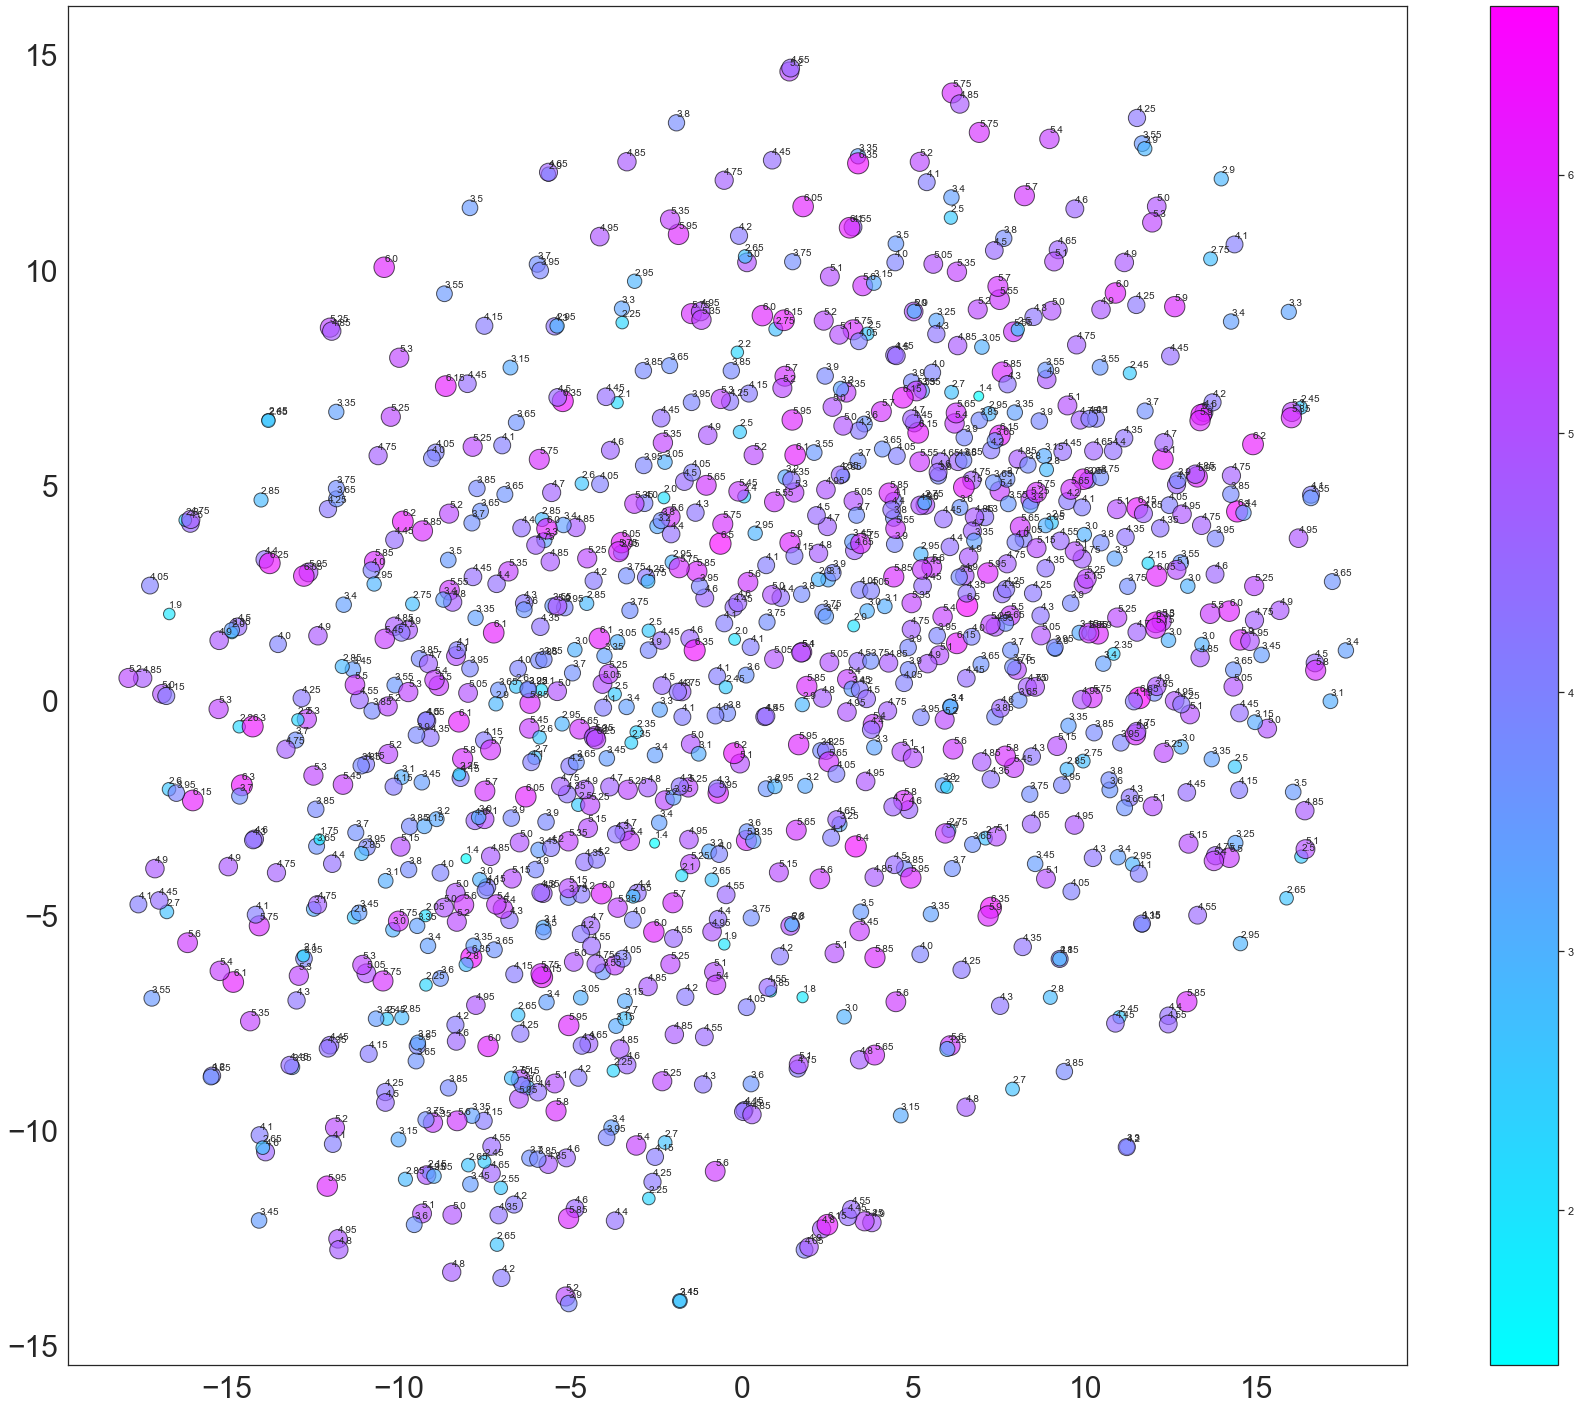

In [112]:
x_for_tsne, y_for_tsne = train_word2vec(post_sentences, list_post)
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

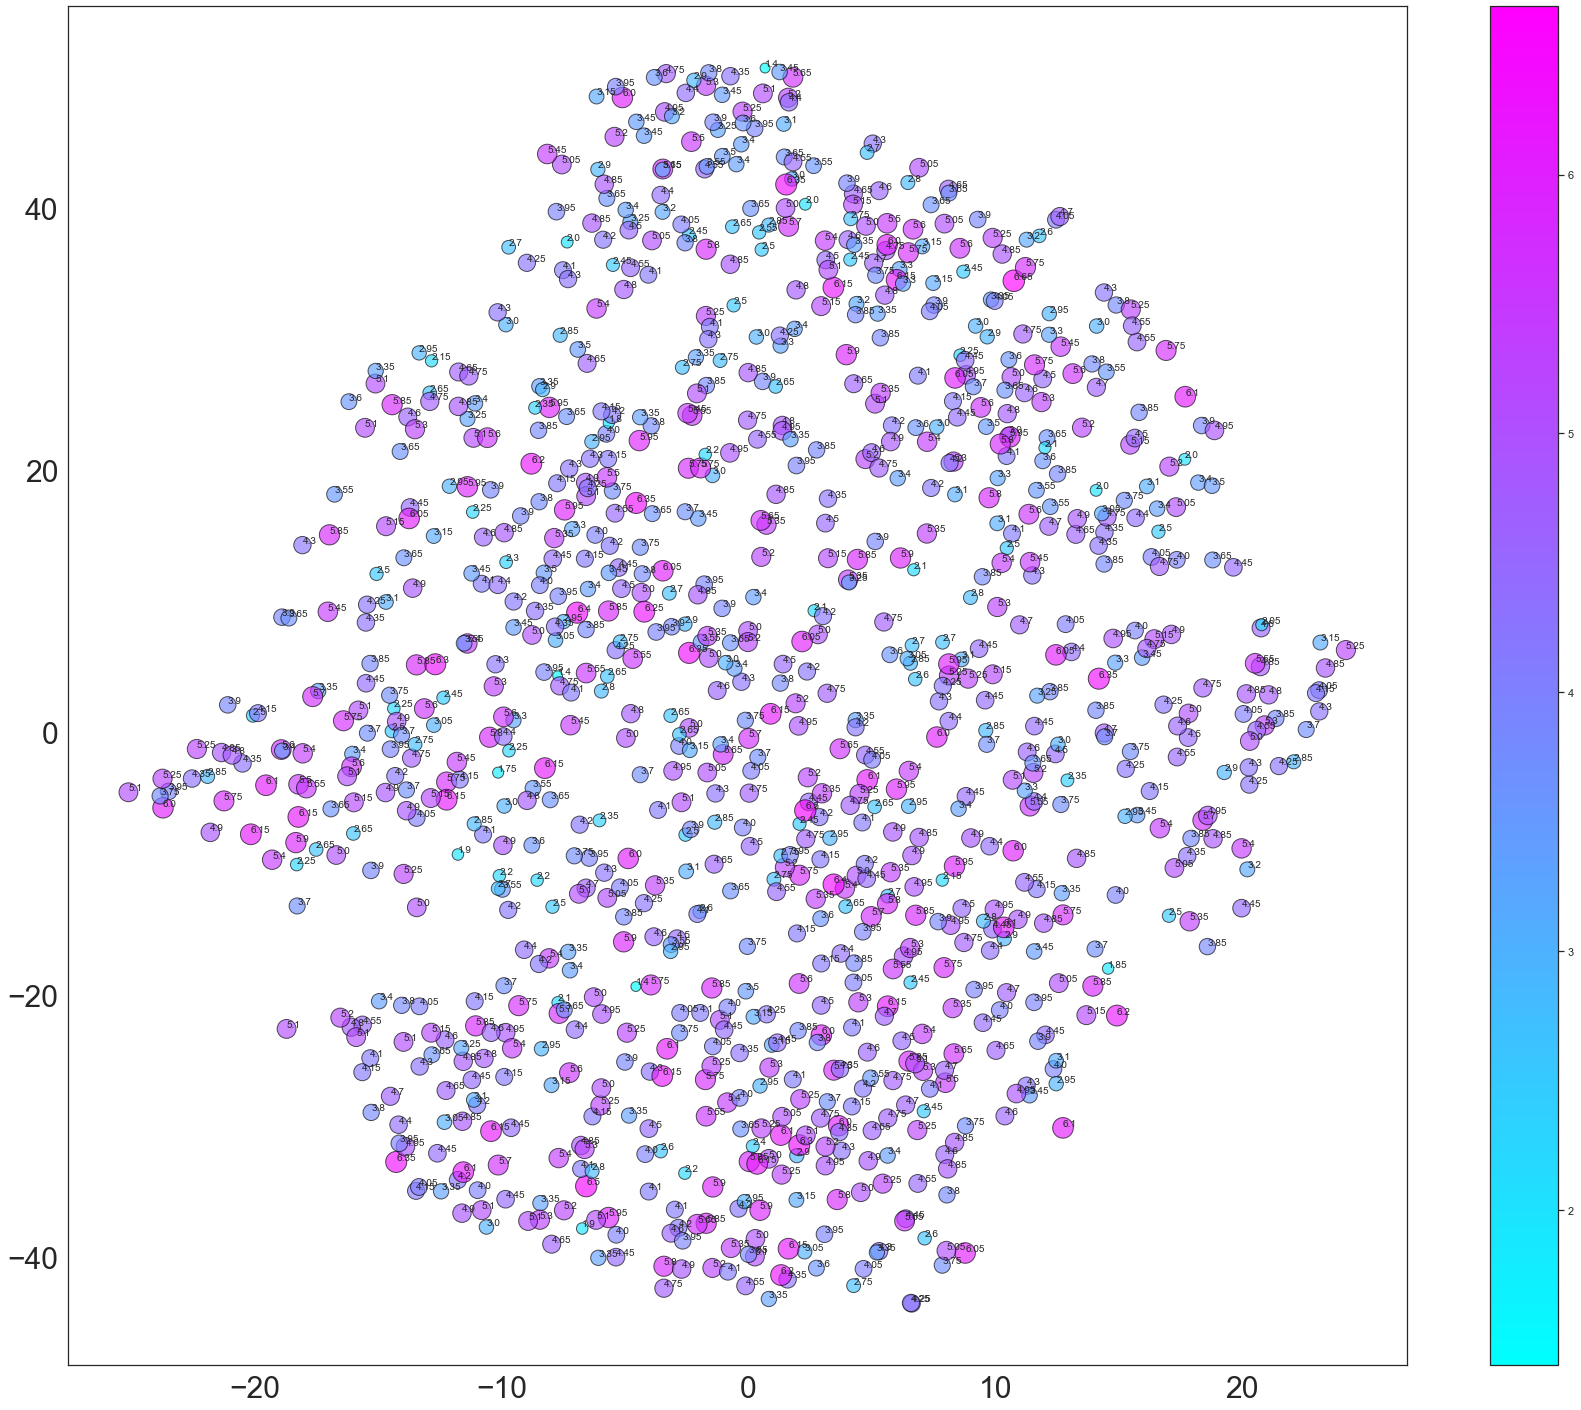

In [104]:
x_for_tsne, y_for_tsne = train_word2vec(comment_sentences, list_comment)
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')